# Predicting Click-Through Rate
## Random Forest / XGBoost

Ryan Koch, Sam Kahr, Julia Kang - AMLI 2019

References: https://towardsdatascience.com/mobile-ads-click-through-rate-ctr-prediction-44fdac40c6ff

## Import Libraries and Data

In [6]:
import pandas as pd
import numpy as np
import multiprocessing as mp
import psutil
import random
import datetime as datetime
import matplotlib.pyplot as plt

In [7]:
# read in the Avazu - criteo labs - csv file
# rand_sample_csv is a randomized subset (1% the size) of the sample_csv which is ~400k instances 

df = pd.read_csv('/home/data/rand_sample_csv.csv')


# Data Exploration

In [8]:
df.head(5)

,Unnamed: 0,Unnamed: 0.1,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,0,236,13120299559997056165,0,14102100,1005,0,543a539e,c7ca3108,3e814130,...,1,0,20362,320,50,2333,0,39,-1,157
1,1,259,13447361190641805430,0,14102100,1005,1,17caea14,0dde25ec,f028772b,...,1,0,19950,320,50,1800,3,167,100075,23
2,2,357,14758321504714974000,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,...,1,0,19743,320,50,2264,3,427,100000,61
3,3,455,16246356889796608406,0,14102100,1005,0,5b08c53b,7687a86e,3e814130,...,1,0,17654,300,250,1994,2,39,100084,33
4,4,540,17569568361412548369,0,14102100,1005,0,543a539e,c7ca3108,3e814130,...,1,0,20362,320,50,2333,0,39,-1,157


In [87]:
df.describe()

,Unnamed: 0,Unnamed: 0.1,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,4184.000000,4184.000000,4.184000e+03,4184.000000,4.184000e+03,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000
mean,2091.500000,202351.664675,9.113168e+18,0.170172,1.410256e+07,1004.977533,0.283222,1.012189,0.331501,18728.379302,318.803059,60.868069,2100.065488,1.412285,229.095841,53381.884082,84.231836
std,1207.961092,116384.632429,5.389524e+18,0.375829,2.963423e+02,1.032567,0.489278,0.488054,0.856303,5058.361185,22.743031,48.729395,621.145767,1.324642,358.883751,49952.289351,70.673532
min,0.000000,236.000000,1.513211e+15,0.000000,1.410210e+07,1002.000000,0.000000,0.000000,0.000000,375.000000,216.000000,36.000000,112.000000,0.000000,33.000000,-1.000000,13.000000
25%,1045.750000,99768.500000,4.449284e+18,0.000000,1.410230e+07,1005.000000,0.000000,1.000000,0.000000,16687.000000,320.000000,50.000000,1800.000000,0.000000,35.000000,-1.000000,23.000000
50%,2091.500000,204607.500000,9.042769e+18,0.000000,1.410260e+07,1005.000000,0.000000,1.000000,0.000000,20312.000000,320.000000,50.000000,2314.000000,2.000000,39.000000,100053.500000,61.000000
75%,3137.250000,301481.250000,1.381808e+19,0.000000,1.410281e+07,1005.000000,1.000000,1.000000,0.000000,21893.000000,320.000000,50.000000,2526.000000,3.000000,169.000000,100084.750000,111.000000
max,4183.000000,404396.000000,1.844673e+19,1.000000,1.410302e+07,1012.000000,7.000000,5.000000,5.000000,24041.000000,728.000000,480.000000,2756.000000,3.000000,1839.000000,100248.000000,255.000000


In [10]:
# looks like clicks were normalized to 1. 
# What is 0.17 of a click, likely the probability of a click. 0 no click, 1 click

In [11]:
df.shape # this sample has 4,184 rows of data with 26 columns

(4184, 26)

In [12]:
df.dtypes
# avazu: "all integer features are categorical variables, all IDs, no numerical meaning"

Unnamed: 0           int64
Unnamed: 0.1         int64
id                  uint64
click                int64
hour                 int64
C1                   int64
banner_pos           int64
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_type          int64
device_conn_type     int64
C14                  int64
C15                  int64
C16                  int64
C17                  int64
C18                  int64
C19                  int64
C20                  int64
C21                  int64
dtype: object

In [13]:
# what do the columns mean?

 - id: ad identifier
 - click: 0/1 for non-click/click
 - hour: format is YYMMDDHH
 - C1 — anonymized categorical variable
 - banner_pos
 - site_id
 - site_domain
 - site_category
 - app_id
 - app_domain
 - app_category
 - device_id
 - device_ip
 - device_model
 - device_type
 - device_conn_type
 - C14-C21 — anonymized categorical variables

In [14]:
# what are the range of unique values of each column
for col in df.columns.values:
    print( "{}".format(len(df[col].unique())))

4184
4184
4184
2
240
5
5
354
292
14
244
32
14
660
3908
871
4
4
675
4
5
279
4
59
105
54


In [15]:
# lets look at an individual user

df[df.id == 13447361190641805430]

,Unnamed: 0,Unnamed: 0.1,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
1,1,259,13447361190641805430,0,14102100,1005,1,17caea14,0dde25ec,f028772b,...,1,0,19950,320,50,1800,3,167,100075,23


# Questions of the data

In [16]:
# At which time do people click ads most frequently?
# where are most clicks coming from? 
# what nique correlations from any or all combinations of each column relate to click?
# what correlations between seemingly unrelated columns (banner_pos and device type, etc.) exist?
# how are banner_pos, device_type, device_conn_type encoded?

# Data Preprocessing

In [17]:
#  unnamed column are columns that are created when a dataframe is converted to a csv. 
# 'Unnamed: 0', 'Unnamed: 0.1' are row indexes which were tansposed into columns.
df_new = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1) 

In [18]:
df_new.shape

(4184, 24)

In [19]:
# how many unique values are in each col?

for col in df_new.columns.values:
    print(str(col)+ ": " +  "{}".format(len(df_new[col].unique())) )
    

id: 4184
click: 2
hour: 240
C1: 5
banner_pos: 5
site_id: 354
site_domain: 292
site_category: 14
app_id: 244
app_domain: 32
app_category: 14
device_id: 660
device_ip: 3908
device_model: 871
device_type: 4
device_conn_type: 4
C14: 675
C15: 4
C16: 5
C17: 279
C18: 4
C19: 59
C20: 105
C21: 54


In [20]:
# check for missing values

df_new.isnull().sum()


id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

In [21]:
# summed list of each column for df_new, looking for inconsistencies

for col in df_new.columns.values:
    total = len(df_new[col].unique())
    print(str(col) + " " + "total: " + str(total))

id total: 4184
click total: 2
hour total: 240
C1 total: 5
banner_pos total: 5
site_id total: 354
site_domain total: 292
site_category total: 14
app_id total: 244
app_domain total: 32
app_category total: 14
device_id total: 660
device_ip total: 3908
device_model total: 871
device_type total: 4
device_conn_type total: 4
C14 total: 675
C15 total: 4
C16 total: 5
C17 total: 279
C18 total: 4
C19 total: 59
C20 total: 105
C21 total: 54


In [22]:
# tried writing an algo to check for erroneous, inconsistent spelling or abbreviations, formatting issues (e.g., odd/unexpected characters or punctuation)
# couldn't work one out... moving on

Each instance of a column are hashed values of an original ID.
Hashing was done to anonymize the services contributing ad data to this dataset.
For illustrative/descriptive purposes we will treat each hashed value as names or in other fictional contexts (e.g.,'7801e8d9' = 'www.overstock.com'). (Thank you Naomi!)

# Feature Engineering
## Hour & Date 

In [23]:
# check hour column data type
df_new.hour.dtype

dtype('int64')

In [24]:
# separate the date and time
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
df_new['new_hour'] = df_new.hour.astype(str).apply(parse_date)
df_new['new_hour']

0      2014-10-21 00:00:00
1      2014-10-21 00:00:00
2      2014-10-21 00:00:00
3      2014-10-21 00:00:00
4      2014-10-21 00:00:00
5      2014-10-21 00:00:00
6      2014-10-21 00:00:00
7      2014-10-21 00:00:00
8      2014-10-21 00:00:00
9      2014-10-21 00:00:00
10     2014-10-21 00:00:00
11     2014-10-21 01:00:00
12     2014-10-21 01:00:00
13     2014-10-21 01:00:00
14     2014-10-21 01:00:00
15     2014-10-21 01:00:00
16     2014-10-21 01:00:00
17     2014-10-21 01:00:00
18     2014-10-21 01:00:00
19     2014-10-21 01:00:00
20     2014-10-21 01:00:00
21     2014-10-21 01:00:00
22     2014-10-21 01:00:00
23     2014-10-21 01:00:00
24     2014-10-21 01:00:00
25     2014-10-21 01:00:00
26     2014-10-21 01:00:00
27     2014-10-21 01:00:00
28     2014-10-21 01:00:00
29     2014-10-21 01:00:00
               ...        
4154   2014-10-30 20:00:00
4155   2014-10-30 20:00:00
4156   2014-10-30 21:00:00
4157   2014-10-30 21:00:00
4158   2014-10-30 21:00:00
4159   2014-10-30 21:00:00
4

In [25]:
# check if column 'new_hour' was created and parsed to string
df_new.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,new_hour
0,13120299559997056165,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,0,20362,320,50,2333,0,39,-1,157,2014-10-21
1,13447361190641805430,0,14102100,1005,1,17caea14,0dde25ec,f028772b,ecad2386,7801e8d9,...,0,19950,320,50,1800,3,167,100075,23,2014-10-21
2,14758321504714974000,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,...,0,19743,320,50,2264,3,427,100000,61,2014-10-21


In [26]:
#confirm dtype of new_hour
df_new.new_hour.dtype

dtype('<M8[ns]')

In [27]:
# create new_date & new_time columns from parsed new_hour column
df_new['date'] = [d.date() for d in df_new['new_hour']]
df_new['time'] = [d.time() for d in df_new['new_hour']]

In [28]:
#check if columns were established properly
df_new.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,new_hour,date,time
0,13120299559997056165,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,320,50,2333,0,39,-1,157,2014-10-21,2014-10-21,00:00:00
1,13447361190641805430,0,14102100,1005,1,17caea14,0dde25ec,f028772b,ecad2386,7801e8d9,...,320,50,1800,3,167,100075,23,2014-10-21,2014-10-21,00:00:00
2,14758321504714974000,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,...,320,50,2264,3,427,100000,61,2014-10-21,2014-10-21,00:00:00


In [29]:
df_new.dtypes

id                          uint64
click                        int64
hour                         int64
C1                           int64
banner_pos                   int64
site_id                     object
site_domain                 object
site_category               object
app_id                      object
app_domain                  object
app_category                object
device_id                   object
device_ip                   object
device_model                object
device_type                  int64
device_conn_type             int64
C14                          int64
C15                          int64
C16                          int64
C17                          int64
C18                          int64
C19                          int64
C20                          int64
C21                          int64
new_hour            datetime64[ns]
date                        object
time                        object
dtype: object

In [30]:
# drop redundant cols
df_tmp = df_new.drop(['new_hour', 'hour'], axis=1)

In [31]:
df_tmp.head(2)

,id,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,C14,C15,C16,C17,C18,C19,C20,C21,date,time
0,13120299559997056165,0,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,...,20362,320,50,2333,0,39,-1,157,2014-10-21,00:00:00
1,13447361190641805430,0,1005,1,17caea14,0dde25ec,f028772b,ecad2386,7801e8d9,07d7df22,...,19950,320,50,1800,3,167,100075,23,2014-10-21,00:00:00


In [32]:
df_tmp.head(2)

,id,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,C14,C15,C16,C17,C18,C19,C20,C21,date,time
0,13120299559997056165,0,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,...,20362,320,50,2333,0,39,-1,157,2014-10-21,00:00:00
1,13447361190641805430,0,1005,1,17caea14,0dde25ec,f028772b,ecad2386,7801e8d9,07d7df22,...,19950,320,50,1800,3,167,100075,23,2014-10-21,00:00:00


In [33]:
# sannity check of summed columns for unique vals

for col in df_tmp.columns.values:
    total = len(df_tmp[col].unique())
    print(str(col) + " " + "total: " + str(total))

id total: 4184
click total: 2
C1 total: 5
banner_pos total: 5
site_id total: 354
site_domain total: 292
site_category total: 14
app_id total: 244
app_domain total: 32
app_category total: 14
device_id total: 660
device_ip total: 3908
device_model total: 871
device_type total: 4
device_conn_type total: 4
C14 total: 675
C15 total: 4
C16 total: 5
C17 total: 279
C18 total: 4
C19 total: 59
C20 total: 105
C21 total: 54
date total: 10
time total: 24


In [34]:
# save to csv to back up work
df_new.to_csv("rf_date_time_sample.csv")

# Features

 - Target feature : click
 - Site features : site_id, site_domain, site_category
 - App feature: app_id, app_domain, app_category
 - Device feature: device_id, device_ip, device_model, device_type, device_conn_type
 - Anonymized categorical features: C14-C21

# Clicks

In [35]:
#see what percentage of people click and what percentage of people do not click
# click = 17%, no click = 83%
df_tmp['click'].value_counts()/4184

0    0.829828
1    0.170172
Name: click, dtype: float64

In [36]:
#Find the start and end date of the dataset
print(df_tmp['date'].min(), df_tmp['date'].max())

2014-10-21 2014-10-30


Our dataset ranges from 10/21/2014 to 10/30/2014. It spans a total of 10 days.

# Data Visualization

### Clicks
0 = no click, 1 = click

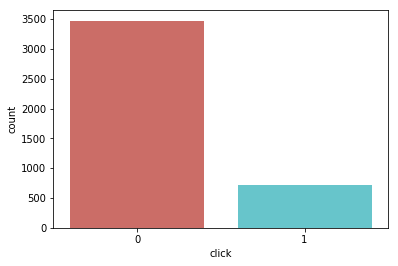

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='click',data=df_tmp, palette='hls')
plt.show();

Text(0.5, 1.0, 'Clicks Trends by Date')

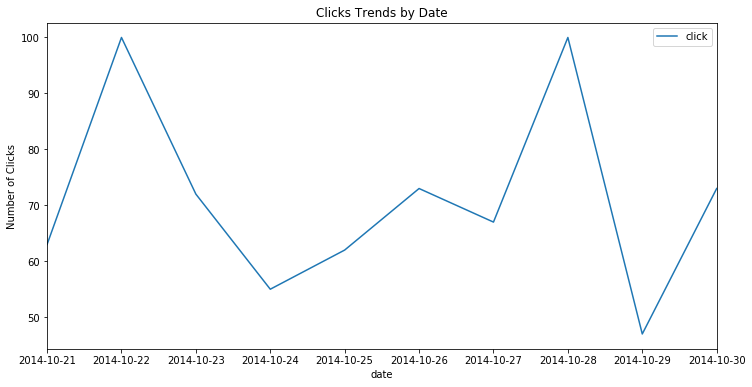

In [40]:
# make groups of summed clicks by date
df_tmp.groupby(['date']).agg({'click': 'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of Clicks')
plt.title('Clicks Trends by Date')


High click rate on Oct. 22nd and OCt. 28
Low click rate on Oct. 24 with lowest rate on Oct. 29

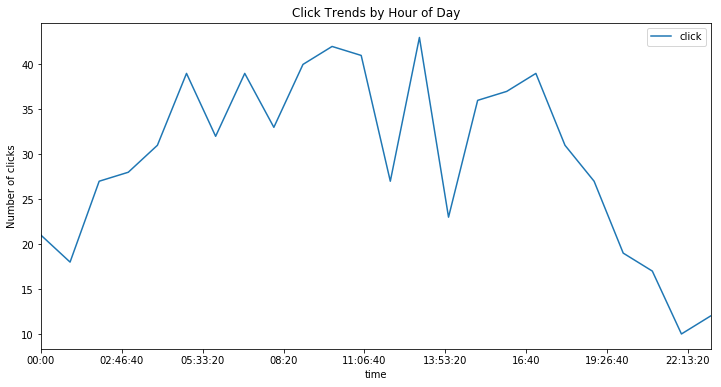

In [42]:
df_tmp.groupby('time').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Click Trends by Hour of Day');

Highest number of clicks is around 2pm with the lowest number of clicks around 10pm

### Click Impressions

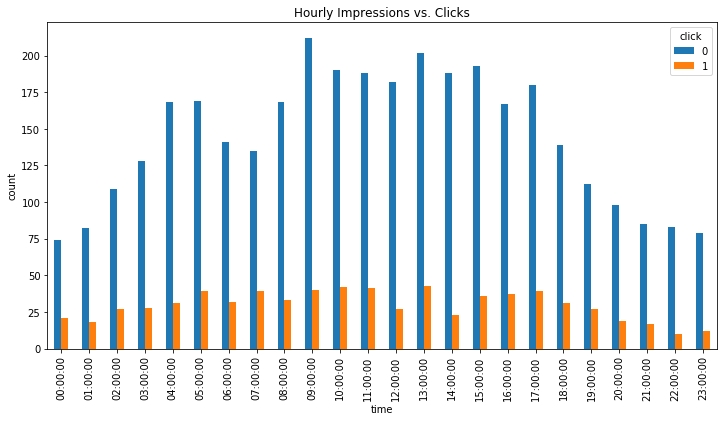

In [43]:
df_tmp.groupby(['time', 'click']).size().unstack().plot(kind='bar', title="Hour of Day", figsize=(12,6))
plt.ylabel('count')
plt.title('Hourly Impressions vs. Clicks');

## Click Through Rate (CTR)

CTR is the ratio of ad clicks to impressions and is a measure of the rate of clicks on each ad.

### Hourly CTR

In [73]:
import seaborn as sns

# make a df for click and df for hour
df_click = df_tmp[df_tmp['click'] == 1]
df_hour = df_tmp[['time','click']].groupby(['time']).count().reset_index()
# reformat time to just hour -- this makes the y axis of the viz more readable
df_hour['time'] = df_hour.time.apply(lambda x: x.hour)

In [74]:
df_click.head(3)

,id,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,C14,C15,C16,C17,C18,C19,C20,C21,date,time
8,691418584948749395,1,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,15702,320,50,1722,0,35,100084,79,2014-10-21,00:00:00
17,13359399510587322432,1,1005,1,17caea14,0dde25ec,f028772b,ecad2386,7801e8d9,07d7df22,...,16208,320,50,1800,3,167,100077,23,2014-10-21,01:00:00
18,13384221001865720388,1,1005,1,cffc1324,bc63ea42,335d28a8,ecad2386,7801e8d9,07d7df22,...,18993,320,50,2161,0,35,-1,157,2014-10-21,01:00:00


In [75]:
df_hour.head(3)

,time,click
0,0,95
1,1,100
2,2,136


In [76]:
# rename column click to impressions
df_hour = df_hour.rename(columns={'click': 'impressions'})

In [77]:
df_hour.impressions

0      95
1     100
2     136
3     156
4     199
5     208
6     173
7     174
8     201
9     252
10    232
11    229
12    209
13    245
14    211
15    229
16    204
17    219
18    170
19    139
20    117
21    102
22     93
23     91
Name: impressions, dtype: int64

In [78]:
df_hour['clicks'] = df_click[['time','click']].groupby(['time']).count().reset_index()['click']

In [79]:
df_hour.clicks

0     21
1     18
2     27
3     28
4     31
5     39
6     32
7     39
8     33
9     40
10    42
11    41
12    27
13    43
14    23
15    36
16    37
17    39
18    31
19    27
20    19
21    17
22    10
23    12
Name: clicks, dtype: int64

In [80]:
# calculate CTR
# rounding impression to nearest int to make labeling of y axis more readable
df_hour['CTR'] = df_hour['clicks']/df_hour['impressions']*100

In [81]:
# check CTR hour
df_hour['CTR'][1:3]

1    18.000000
2    19.852941
Name: CTR, dtype: float64

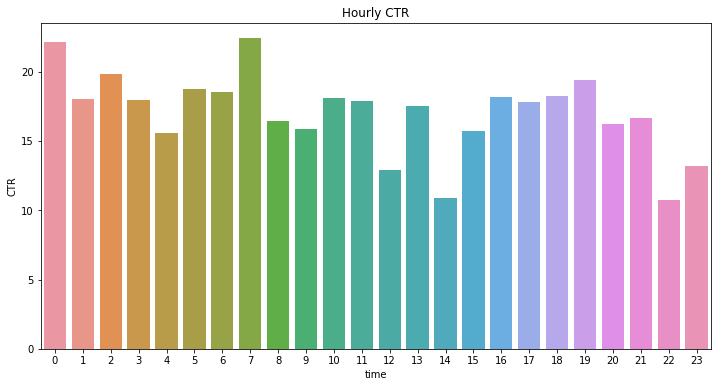

In [82]:
# plot CTR
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='time', data=df_hour)
plt.title('Hourly CTR');

Highest CTRs are after 10pm which is odd because after 10pm is the least number of impressions and clicks

## Day of Week (DoW)
### DoW Feature Engineering and Visualizations

In [99]:
# copy df_tmp to new df called df_dow
df_dow = df_tmp

In [101]:
df_dow.head(3)

,id,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,C14,C15,C16,C17,C18,C19,C20,C21,date,time
0,13120299559997056165,0,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,...,20362,320,50,2333,0,39,-1,157,2014-10-21,00:00:00
1,13447361190641805430,0,1005,1,17caea14,0dde25ec,f028772b,ecad2386,7801e8d9,07d7df22,...,19950,320,50,1800,3,167,100075,23,2014-10-21,00:00:00
2,14758321504714974000,0,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,0f2161f8,...,19743,320,50,2264,3,427,100000,61,2014-10-21,00:00:00


In [142]:
# change date to numeric to make 'dt' method usable
df_dow['date'] = pd.to_datetime(df_dow['date'])

In [143]:
# make 'day_of_week' date into string representation of day of the week
df_dow['day_of_week'] = df_dow['date'].dt.weekday_name

In [144]:
df_dow.head(3)

,id,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,C15,C16,C17,C18,C19,C20,C21,date,time,day_of_week
0,13120299559997056165,0,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,...,320,50,2333,0,39,-1,157,2014-10-21,00:00:00,Tuesday
1,13447361190641805430,0,1005,1,17caea14,0dde25ec,f028772b,ecad2386,7801e8d9,07d7df22,...,320,50,1800,3,167,100075,23,2014-10-21,00:00:00,Tuesday
2,14758321504714974000,0,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,0f2161f8,...,320,50,2264,3,427,100000,61,2014-10-21,00:00:00,Tuesday


In [145]:
# check if date vals were encoded properly
df_dow.day_of_week.nunique()

7

In [146]:
# remember dataset ranges from 10/21/2014 to 10/30/2014
# 10/21/2014 is a tuesday and is the first day of the dataset
df_dow.day_of_week[0]

'Tuesday'

In [147]:
# groupby and reindex based on day of week

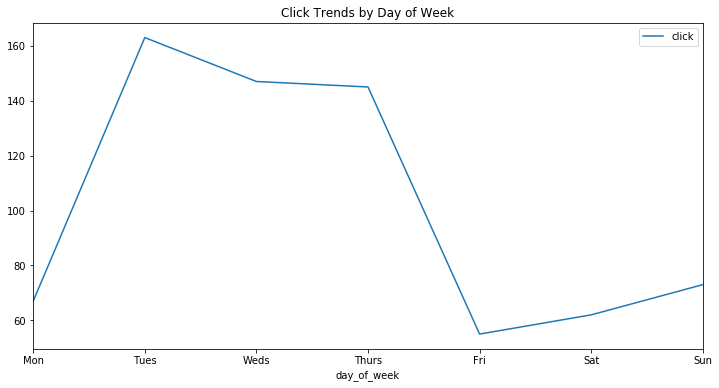

In [148]:
#cats = {7:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_dow.groupby('day_of_week').agg({'click':'sum'}).reindex(cats).plot(figsize=(12,6))
# change ticks to match x axis label
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('Click Trends by Day of Week');

Looks like highest number of clicks are on Tuesday with the lowest number of clicks on Friday

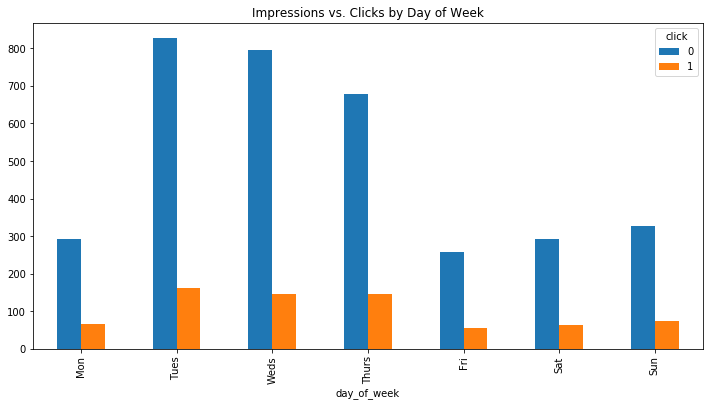

In [150]:
# group by day_of_week and click and plot bar chart of clicks/impressions by day_of_week
df_dow.groupby(['day_of_week','click']).size().unstack().reindex(cats).plot(kind='bar', title="Day of the Week", figsize=(12,6))

# change ticks to match x axis label
ticks = list(range(0, 7, 1))
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()

# plot
plt.xticks(ticks, labels)
plt.title('Impressions vs. Clicks by Day of Week');

Tuesday - Thurs. have most number of impressions and clicks. Mon. & Friday have the least amount of clicks & impressions.

## Day of Week CTR

In [152]:
# make df of positive hits / clicks = 1
df_click = df_dow[df_dow['click'] == 1]

In [154]:
# make df_dayofweek with just dow and click data
df_dayofweek = df_dow[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()

In [155]:
df_dayofweek.head(3)

,day_of_week,click
0,Friday,313
1,Monday,359
2,Saturday,355


In [164]:
# rename clicks to impressions to disambiguate 'click'. Impressions are clicks = 0 or false postivies
df_dayofweek = df_dayofweek.rename(columns={'click': 'impressions'})

In [157]:
df_dayofweek.head(3)

,day_of_week,impressions
0,Friday,313
1,Monday,359
2,Saturday,355


In [161]:
# add 'clicks' column of only positive hits for click (clicks = 1)
df_dayofweek['clicks'] = df_click[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()['click']

In [162]:
df_dayofweek['clicks']

0     55
1     67
2     62
3     73
4    145
5    163
6    147
Name: clicks, dtype: int64

In [163]:
df_dayofweek.head(3)

,day_of_week,impressions,clicks
0,Friday,313,55
1,Monday,359,67
2,Saturday,355,62


In [165]:
# calculate CTR 
df_dayofweek['CTR'] = df_dayofweek['clicks']/df_dayofweek['impressions']*100

In [166]:
df_dayofweek['CTR']

0    17.571885
1    18.662953
2    17.464789
3    18.204489
4    17.618469
5    16.464646
6    15.588547
Name: CTR, dtype: float64

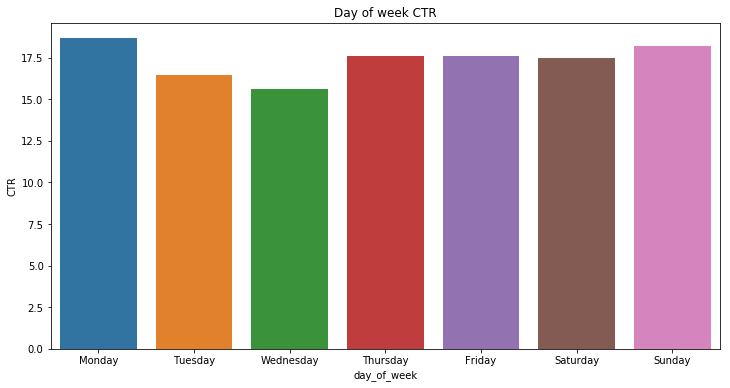

In [168]:
# plot day of week CTR
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='day_of_week', data=df_dayofweek, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Day of week CTR');

Tues & Weds. have the highest number of impressions and clicks but the lowest CTR. Saturday & Monday have the highest CTR.

## C1 

In [170]:
# check out distribution of C1 across all columns
print(df_tmp.C1.value_counts()/len(df_tmp))

1005    0.930449
1002    0.047084
1010    0.018642
1012    0.003585
1007    0.000239
Name: C1, dtype: float64


C1 (value = 1005) is about 93% of all the data we are using. 

### C1 Feature engineering and visualization
Investigate value of C1 in relation to CTR.

In [180]:
# check unique vals for C1
C1_values = df_tmp.C1.unique()

In [181]:
print(C1_values) # there are 5 unique vals

[1005 1002 1010 1012 1007]


In [177]:
# sort C1 vals
C1_values.sort()

In [178]:
# instantiate empty list for avg CTR vals
ctr_avg_list=[]

In [179]:
# look up C1s click mean vals, append values to ctr_avg list, print results
for i in C1_values:
    ctr_avg=df_tmp.loc[np.where((df_tmp.C1 == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for C1 value: {},  click through rate: {}".format(i,ctr_avg))

for C1 value: 1002,  click through rate: 0.18781725888324874
for C1 value: 1005,  click through rate: 0.1703056768558952
for C1 value: 1007,  click through rate: 0.0
for C1 value: 1010,  click through rate: 0.10256410256410256
for C1 value: 1012,  click through rate: 0.26666666666666666


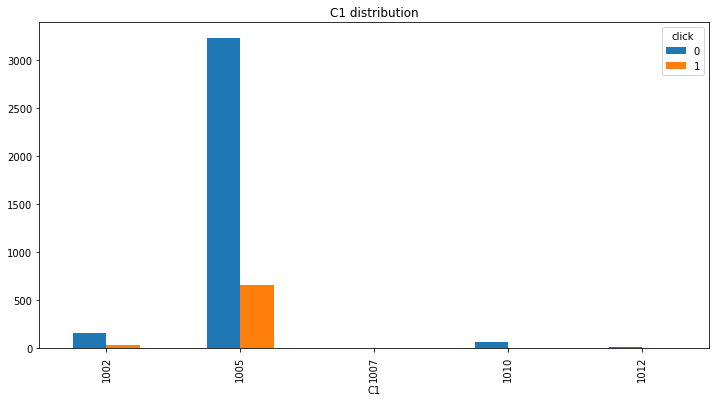

In [183]:
# group C1 with click and plot distribution
df_tmp.groupby(['C1', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C1 distribution');

It appears that C1 values of '1005' have the most clicks and impressions